# Exploring and Benchmarking XGBoost Against Other Machine Learning Models
### Jake Bova and Brianna Daniels

---

## Part I: Understanding XGBoost

### What is XGBoost?

XGboost, which stands for "Extreme Gradient Boosting", is an open source software who's algorithm uses gradient boosting to provide better performing models. Similar to trees we have seen in class, averages or the majority class are considered when outputing a result.$^{[1]}$

Gradient Boosting is an ensemble method that trains sequential models on the errors, or residuals, of previous models, thus creating a strong learner via iteration on many weak learners. $^{[2, p. 92]}$ $^{[3]}$

Boositng and other ensemble methods were popularized due standard decision trees overfitting data. Boosting allowed for a more generalizable model with "consistency and power".$^{[2, p. 110]}$

### Why XGBoost?

As mentioned above, XGBoost provides better performing models. This is due to some key advantages that XGBoosts provides than standard boosting methods we have seen in scikit-learn. A few of these advantages are that XGBoost is:

- extrememly fast,
- ability to handle and learn with missing values,
- memory efficient by storing sparce matrices,
- computes in parallel,
- improved accuracy, 
- and can perform advance model operations. $^{[4]}$ $^{[2, p. 57, 129]}$  

While speed will vary from computer to computer, XGBoost is known for its speed. The original XGBoost paper detailed performance 50 times faster than a standard approach on the same dataset. $^{[2, p. 112]}$

Speed is also due to the fact that XGBoost can compute in parallel, meaning multiple processes can be done at the same time, by putting data into "blocks". These blocks are then sent to multiple machines or external memory to "expedite the model-building process". $^{[2, p. 112]}$

Improved accuracy can be attributed to XGBoost's built-in regularization where information is added to "reduce variance and prevent overfitting". $^{[2, p. 112]}$

### XGBoost Parameters

XGBoost is easy to use with scikit-learn since "all standard methods are available" (such as fit) and scikit-learn's functions like train_test_split, and GridSearchCV can be combined with XGBoost models. $^{[2, p. 117]}$

However, there are some differences with XGBoost, namely the hyperparameters used to build models. Some hyperparameters are required to build a specific model: 

- General parameters determine what booster we will be using. Default is "gbtree".$^{[5]}$
- Booster parameters will depend on the general parameter chosen. These are similar to hyperparameters we've seen for different models. $^{[5]}$
- Learning task parameters determine the "objective", or scoring metric, and the evaluation metric. Default is "reg:squarederror". $^{[5]}$

XGBoost hyperparemeters "are designed to improve upon accuracy and speed" of existing models and tuning them can be done using scikit-learn's GridSearchCV. $^{[2, p. 130]}$ 

A few Hyperparameters of that are similar to scikit-learn's hyperparameters are below for reference:

<img src="../images/XGBoost_hyperparameters.png" alt="Some of XGBoost's core hyperparameters" style="width: 500px;"/>


### How to use XGBoost?

#### Installation and Setup

Installation from XGBoost documentation:

##### **Conda**:
conda install -c conda-forge py-xgboost

##### **Pip**:
pip install xgboost

In [ ]:
# building the model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(booster='gbtree')

In [ ]:
# importing the data
from sklearn.datasets import load_wine
wine = load_wine()

# splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, random_state=0)

In [ ]:
# about 40 seconds to run

# grid search to find the best parameters (using some parameters from above list)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'max_depth': [2, 5, 10],
    'min_child_weight': [1, 2, 4, 8, 16], # min_saples_leaf
}

grid_xgb = GridSearchCV(xgb, param_grid, scoring='accuracy', n_jobs=-1)

grid_xgb.fit(X_train, y_train)

In [ ]:
grid_xgb.best_params_

In [ ]:
grid_xgb.best_score_

In [ ]:
# accuracy on training data
xgb_best = grid_xgb.best_estimator_

y_pred_train = xgb_best.predict(X_train)

score = accuracy_score(y_pred_train, y_train)
print('Training Score: ' + str(score))


In [ ]:
# accuracy on testing data
y_pred = xgb_best.predict(X_test)

score = accuracy_score(y_pred, y_test)
print('Testing Score: ' + str(score))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')

---

## Part II: Performance Comparison of XGBoost

### <u>Benchmarking Goals</u>

The objectives of the performance comparison are to:
- Compare the performance of XGBoost against other machine learning models.
- Identify the best model for the given dataset (may or may not be XGBoost).

### <u>Selection of Competing Models</u>

For <u>classification</u>, we're using five machine learning models for comparison. Here is a brief description of each:

1. **MLP (Multi-Layer Perceptron)**: A type of neural network with multiple hidden layers, effective for complex classification tasks.

2. **k-NN (k-Nearest Neighbors)**: Simple for low-dimensional data but computationally heavy for large datasets.

3. **Random Forest**: A popular method using multiple decision trees, effective for both classification and regression.

4. **SVM (Support Vector Machine)**: Effective in high-dimensional spaces but can be slower than gradient boosting methods.

5. **XGBoost (Extreme Gradient Boosting)**: Highly efficient and versatile, suitable for various supervised learning tasks.

For <u>regression</u>, we're using the same methods as above, but replacing k-NN with **Linear Regression** - a simple yet effective model for regression tasks.


### <u>Performance Metrics</u>

For our classification models, we use six metrics to evaluate performance:

1. **Accuracy**: Ratio of correct predictions. Useful overall but can mislead in imbalanced datasets.

2. **Precision**: Ratio of correct positive predictions. Vital when false positives are costly.

3. **Recall**: Ratio of correct positives out of all actual positives. Key when false negatives are costly.

4. **F1-Score**: Balances Precision and Recall. Used when both metrics are important.

5. **AUC-ROC**: Indicates the model's ability to differentiate classes. Higher values are better.

6. **Training Time**: Measures computational efficiency, important in scenarios with computational constraints.

For our regression models, we use four metrics to evaluate performance:

1. **Mean Absolute Error (MAE)**: Average of absolute errors. Useful for datasets with outliers.

2. **Mean Squared Error (MSE)**: Average of squared errors. Useful for datasets without outliers.

3. **R^2 Score**: Measures the proportion of variance in the dependent variable explained by the model.

4. **Training Time**: Measures computational efficiency, important in scenarios with computational constraints.

### <u>Dataset Description</u>

#### Dataset 1: [The Titanic Dataset](https://www.kaggle.com/c/titanic/data) (famous for classification problems):
| Attribute  | Description                                       | Key                                        |
|-----------|-------------------------------------------------|--------------------------------------------|
| PassengerId | Unique ID for each passenger                   |                                            |
| Name      | Passenger name                                   |                                            |
| pclass    | Ticket class                                     | 1 = 1st, 2 = 2nd, 3 = 3rd                  |
| sex       | Sex                                              |                                            |
| Age       | Age in years                                     |                                            |
| sibsp     | # of siblings / spouses aboard the Titanic       |                                            |
| parch     | # of parents / children aboard the Titanic       |                                            |
| ticket    | Ticket number                                    |                                            |
| fare      | Passenger fare                                   |                                            |
| cabin     | Cabin number                                     |                                            |
| embarked  | Port of Embarkation                              | C = Cherbourg, Q = Queenstown, S = Southampton |
| survived  | Survived or not                                         | 0 = No, 1 = Yes                            |


#### Dataset 2: [The Boston Housing Dataset](https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data) (famous for regression problems):
| Attribute | Description                                           | Unit        |
|-----------|-------------------------------------------------------|-------------|
| CRIM      | Per capita crime rate by town                         | -           |
| ZN        | Proportion of residential land zoned for large lots   | -           |
| INDUS     | Proportion of non-retail business acres per town      | -           |
| CHAS      | Charles River dummy variable                          | 1 or 0      |
| NOX       | Nitric oxides concentration                           | parts/10M   |
| RM        | Average number of rooms per dwelling                  | -           |
| AGE       | Proportion of owner-occupied units built pre-1940     | -           |
| DIS       | Weighted distances to five Boston employment centres | -           |
| RAD       | Index of accessibility to radial highways             | -           |
| TAX       | Full-value property-tax rate                          | $/10k       |
| PTRATIO   | Pupil-teacher ratio by town                           | -           |
| MEDV      | Median value of owner-occupied homes                  | k$          |


### <u>Cross-Validation Strategy</u>

For the tuned models, we use 5-fold cross-validation to ensure fairness in comparison. For each model, we use the same cross-validation folds to train and evaluate the model. We also use the same random seed for each model to ensure that the folds are identical across models.

For the untuned models, we use a single train-test split to train and evaluate the model. We use the same random seed for each model to ensure that the train-test split is identical across models.

### <u>Hyperparameter Tuning</u>

We use a grid search to tune the hyperparameters of each model with 5-fold cross-validation. The parameters and ranges used for each model are are chosen based on the model's documentation and best practices. The grid search is performed using the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function from scikit-learn.

### <u>Model Training and Evaluation</u>
- Train the selected models on the dataset.
- Evaluate and compare their performance using the defined metrics.

We are comparing both classification and regression.  For classification, we are using the Titanic dataset.  We fit to a simple reduced and feature mapped version of the dataset, as well as a complex heavily feature processed version of the dataset.

For regression, we are using the Boston Housing dataset.

In [67]:
# IMPORTS
# Standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# Sklearn modules
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, average_precision_score, classification_report, confusion_matrix, 
                             f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, 
                             roc_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder, 
                                   PolynomialFeatures, StandardScaler)
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression, LogisticRegression

# Third-party libraries
from xgboost import XGBClassifier, XGBRegressor

# pd max cols
pd.set_option('display.max_columns', 100)

In [ ]:
# NOT USED IN PROJECT BUT LEAVING FOR REFERENCE

def titanic_data_transformed(t_data):

    # Group ticket feature extraction
    group_tickets = t_data['Ticket'].value_counts() > 1
    t_data['Is_Group'] = t_data['Ticket'].apply(lambda x: 1 if group_tickets[x] else 0)
    t_data['Group_Size'] = t_data['Ticket'].map(t_data['Ticket'].value_counts())

    # Functions for title and family size extraction
    def get_title(data):
        titles = data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
        common_titles = titles.value_counts().nlargest(6).index
        return titles.where(titles.isin(common_titles), 'Other')

    def get_family_size(data):
        return data['SibSp'] + data['Parch'] + 1

    # Transformation pipelines
    numerical_features = ['Age', 'Fare', 'FamilySize', 'Group_Size']
    numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    categorical_features = ['Sex', 'Embarked', 'Title', 'Pclass']
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Apply the custom transformations
    t_data['Title'] = get_title(t_data)
    t_data['FamilySize'] = get_family_size(t_data)

    # Column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    # Fit the transformer and transform the data
    transformed_data = preprocessor.fit_transform(t_data)

    # Getting the column names for numerical features
    numerical_cols = numerical_features

    # Getting the column names for categorical features
    categorical_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)

    # Combine all column names
    all_cols = list(numerical_cols) + list(categorical_cols)

    # Add any remaining columns that were 'passed through'
    pass_through_cols = [col for col in t_data.columns if col not in numerical_features + categorical_features]
    all_cols.extend(pass_through_cols)

    # Create the DataFrame
    transformed_df = pd.DataFrame(transformed_data, columns=all_cols)

    transformed_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

    # Set all dtypes to float
    transformed_df = transformed_df.astype(float)

    return transformed_df

In [68]:
# # Load Titanic data
t_data = pd.read_csv('../../data_science_analytics_class/Data/titanic.csv')

t_data_reduced = t_data.drop(columns=['Name', 'Ticket', 'Cabin'])
titanic_data = t_data_reduced

# map Embarked to numeric values and sex to numeric values
titanic_data['Embarked'] = titanic_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 1, 'female': 0})

# fill missing age with mean based on Pclass
titanic_data['Age'] = titanic_data['Age'].fillna(titanic_data.groupby('Pclass')['Age'].transform('mean'))

# drop missing embarked rows
titanic_data.dropna(subset=['Embarked'], inplace=True)

# Load transformed titanic data
# titanic_data = titanic_data_transformed(t_data)

# Load Boston housing data
b_data = pd.read_csv('../../data_science_analytics_class/Data/boston_housing.csv')

##### Classification 
---

Default params:

In [70]:
# DEFAULT PARAMS ALL MODELS

# Feature matrix X, target vector y
X = titanic_data.drop(['Survived'], axis=1)
y = titanic_data['Survived']


models = {
    "MLP": MLPClassifier(max_iter=1000),
    "k-NN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier()
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    end = time.time()
    training_time = end - start
    scores = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted'),
        # "AUC-ROC": roc_auc_score(y_test, y_score, average='weighted'),
        # "AUC-PR": average_precision_score(y_test, y_score, average='weighted'), # Not directly supported for multiclass
        "Training Time": training_time
    }
    # Create plots to add to dictionary
    cm = confusion_matrix(y_test, y_pred)
    cm_display_data = (cm, model.classes_)
    
    # Store the model and test set for ROC curve plotting
    roc_data = (model, X_test, y_test)

    plots = {
        "Confusion_Matrix": cm_display_data,
        "ROC_Curve": roc_data
    }
    return scores, plots

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

results = {}
plots = {}
for name, model in models.items():
    results[name], plots[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

results_df = pd.DataFrame(results)
def highlight_min_or_max(s):
    if s.name in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:  # Adjust indices as needed
        is_highlight = s == s.max()
    elif s.name == 'Training Time':  # Adjust index as needed
        is_highlight = s == s.min()
    else:
        is_highlight = [False] * len(s)  # No highlight for other columns
    return ['background-color: green' if cell else '' for cell in is_highlight]
# Transpose the DataFrame for better readability
results_df_transposed = results_df.T
# Apply the highlighting style
styled_results_classification = results_df_transposed.style.apply(highlight_min_or_max).set_precision(3)
styled_results_classification

C:\Users\bovam\AppData\Local\Temp\ipykernel_14736\2342740577.py:64: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  styled_results_classification = results_df_transposed.style.apply(highlight_min_or_max).set_precision(3)


,Accuracy,Precision,Recall,F1-Score,Training Time
MLP,0.735,0.729,0.735,0.726,0.398
k-NN,0.610,0.590,0.610,0.595,0.020
Random Forest,0.798,0.797,0.798,0.797,0.325
SVM,0.655,0.679,0.655,0.558,0.168
XGBoost,0.803,0.800,0.803,0.800,0.094


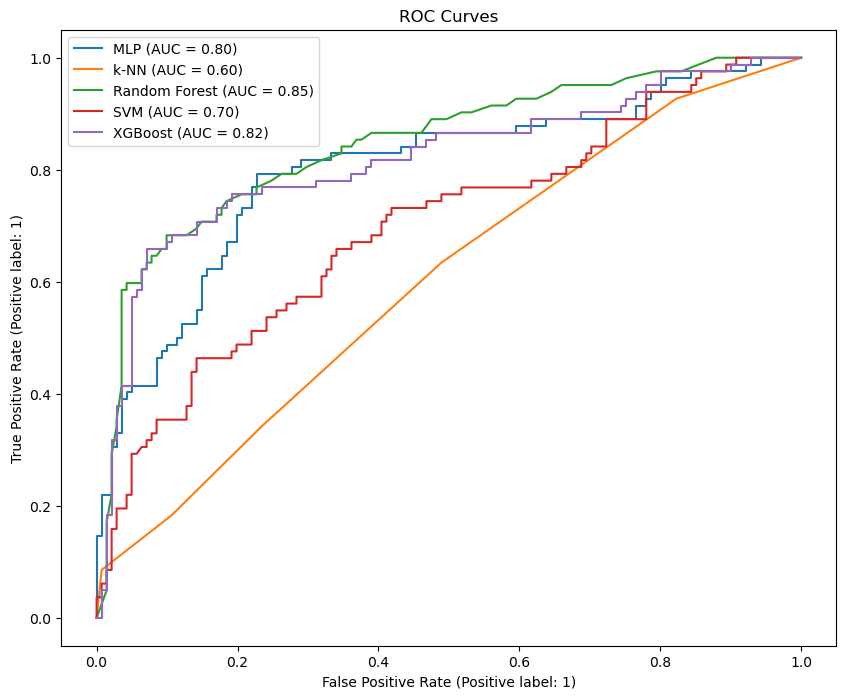

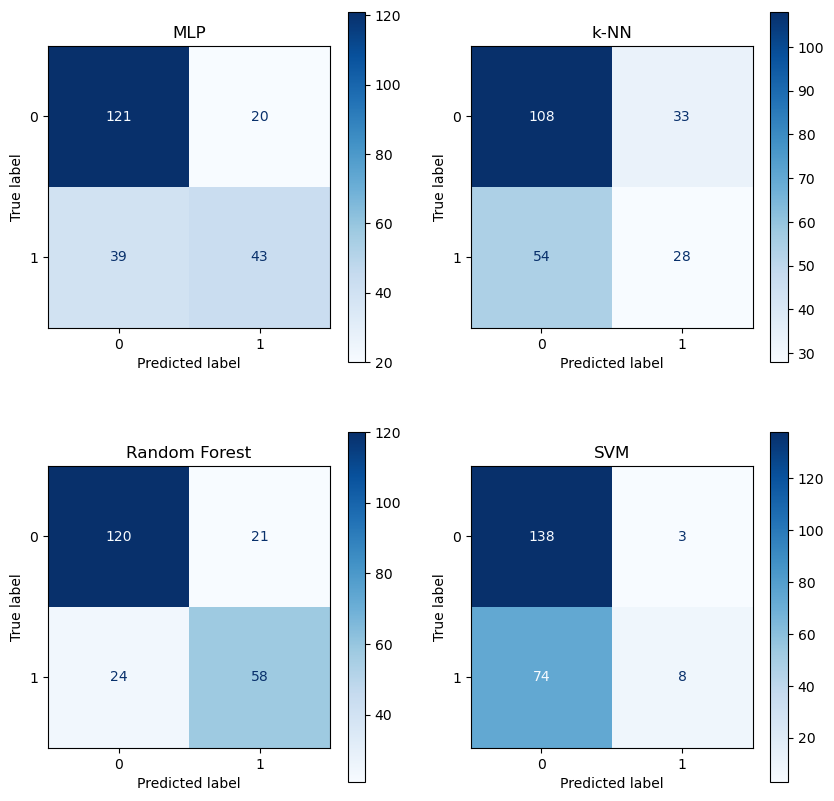

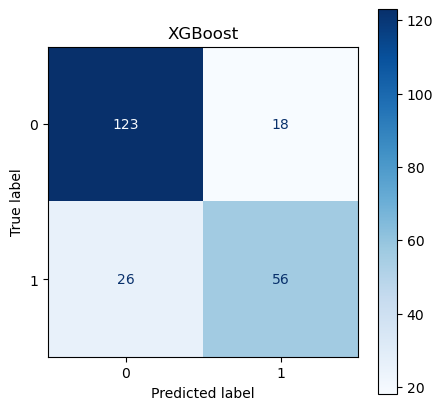

In [71]:
# Plot ROC curves in a separate figure
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
for model_name in models.keys():
    model, X_test, y_test = plots[model_name]["ROC_Curve"]
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax_roc, name=model_name)
ax_roc.set_title('ROC Curves')
ax_roc.legend()
# save the figure
plt.savefig('../images/roc_curves_default.png')
plt.show()

# Plot confusion matrices in another separate figure
fig_cm, axes_cm = plt.subplots(nrows=2, ncols=2, figsize=(10, 10)) # plotting 2x2, the first 4 models in models dict
for ax, model_name in zip(axes_cm.flatten(), models.keys()):
    cm, labels = plots[model_name]["Confusion_Matrix"]
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, cmap='Blues')
    ax.set_title(model_name)
# save the figure
plt.savefig('../images/confusion_matrices_default_compare.png')

fig_cm_xgb, ax_cm_xgb = plt.subplots(figsize=(5, 5))
cm, labels = plots["XGBoost"]["Confusion_Matrix"]
ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax_cm_xgb, cmap='Blues')
ax_cm_xgb.set_title("XGBoost")
# save the figure
plt.savefig('../images/confusion_matrices_default_xgb.png')

Tuned params:

In [ ]:
# TUNED PARAMS ALL MODELS
from sklearn.model_selection import RandomizedSearchCV

# Feature matrix X, target vector y
X = titanic_data.drop(['Survived'], axis=1)
y = titanic_data['Survived']

# Define the models and their corresponding parameter grids
model_params = {
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200, 250, 300],
            "max_depth": [4, 8, 16, None],
            "min_samples_split": [2, 4, 8],
            "min_samples_leaf": [1, 2, 4, 8],
        }
    },
    "XGBoost": {
        "model": XGBClassifier(),
        "params": {
            "n_estimators": [100, 200, 250, 300],
            "learning_rate": [0.05, 0.1, 0.3],
            "max_depth": [4, 8, 16, None],
            "min_child_weight": [1, 2, 4, 8],
            "gamma": [0, 0.1, 0.2],
            "alpha": [0, 0.1, 0.2],
            "lambda": [0, 0.1, 0.2],
        }
    }
}

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Function to perform grid search and evaluate each model
def grid_search_model(model_info, X_train, X_test, y_train, y_test):
    # grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=3, n_jobs=-1, verbose=3)
    grid_search = RandomizedSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1, verbose=3)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    scores = {
        "Best Parameters": grid_search.best_params_,
        "Best Score": grid_search.best_score_,
        "Test Accuracy": accuracy_score(y_test, y_pred)
        # Add other metrics as needed
    }
    return scores, best_model

def highlight_min_or_max(s):
    if s.name in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:  # Adjust indices as needed
        is_highlight = s == s.max()
    elif s.name == 'Training Time':  # Adjust index as needed
        is_highlight = s == s.min()
    else:
        is_highlight = [False] * len(s)  # No highlight for other columns
    return ['background-color: green' if cell else '' for cell in is_highlight]

# Evaluate each model
grid_results = {}
best_models = {}
for name, model_info in model_params.items():
    grid_results[name], best_models[name] = grid_search_model(model_info, X_train, X_test, y_train, y_test)

# Convert results to DataFrame for display
grid_results_df = pd.DataFrame(grid_results).T
styled_grid_results_classification = grid_results_df.style.apply(highlight_min_or_max).set_precision(3)
styled_grid_results_classification

In [65]:
styled_grid_results_classification

,Best Parameters,Best Score,Test Accuracy
Random Forest,"{'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 8}",0.833,0.816
XGBoost,"{'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.05, 'lambda': 0.1, 'gamma': 0.1, 'alpha': 0.2}",0.829,0.812


In [ ]:
# multiple runs of grid search to get average metrics
grid_results = {}
best_models = {}

accuracies = {
    "Random Forest": [],
    "XGBoost": []
}

for i in range(10):
    for name, model_info in model_params.items():
        grid_results[name], best_models[name] = grid_search_model(model_info, X_train, X_test, y_train, y_test)
        accuracies[name].append(grid_results[name]['Test Accuracy'])

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

In [64]:
print("Test Accuracy Mean on 500 Randomized Grid Search Trials")
print(accuracies_df.mean())

Test Accuracy Mean on 500 Randomized Grid Search Trials
Random Forest    0.801794
XGBoost          0.816592
dtype: float64


##### Regression
---

Default params:

In [ ]:
# Feature matrix X, target vector y
X = b_data.drop(['MEDV'], axis=1)
y = b_data['MEDV']

models = {
    "MLP": MLPRegressor(max_iter=10000),
    "LinearRegression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "XGBoost": XGBRegressor()
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()
    training_time = end - start
    scores = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R^2": r2_score(y_test, y_pred),
        "Training Time": training_time
    }
    return scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

results = {}
plots = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)
    # Add info for plots (actual vs predicted)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plots[name] = (y_test, y_pred)

results_df = pd.DataFrame(results)
def highlight_min_or_max(s):
    if s.name in ['MAE', 'MSE', 'Training Time']:  # Adjust indices as needed
        is_highlight = s == s.min()
    elif s.name == 'R^2':  # Adjust index as needed
        is_highlight = s == s.max()
    else:
        is_highlight = [False] * len(s)  # No highlight for other columns
    return ['background-color: green' if cell else '' for cell in is_highlight]

# Transpose the DataFrame for better readability
results_df_transposed = results_df.T

# Apply the highlighting style and set precision
styled_results_regression = results_df_transposed.style.apply(highlight_min_or_max).format(precision=3)
styled_results_regression

In [63]:
styled_results_regression

,MAE,MSE,R^2,Training Time
MLP,2.733,14.584,0.792,0.924
LinearRegression,3.061,22.099,0.684,0.005
Random Forest,2.212,11.255,0.839,0.535
SVR,4.462,49.284,0.296,0.020
XGBoost,2.140,10.061,0.856,0.099


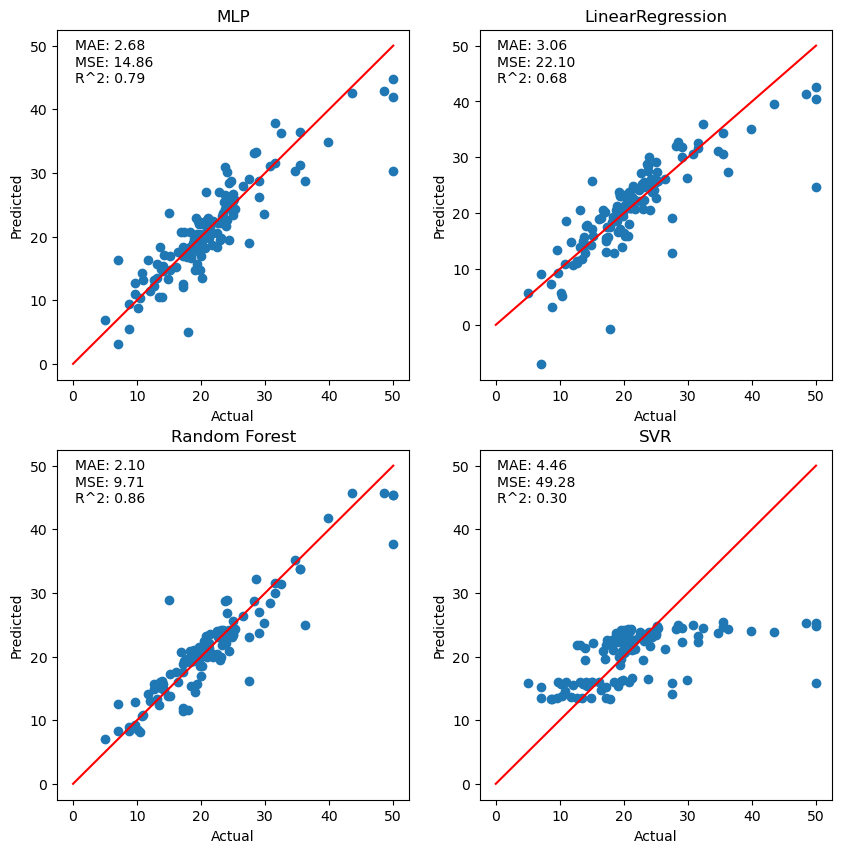

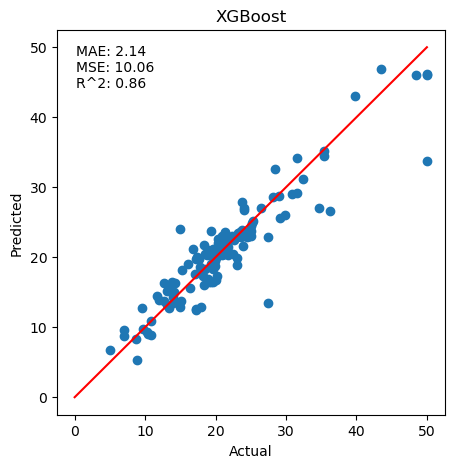

In [62]:
# Plot actual vs predicted in a separate figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))  # plotting 2x2, the first 4 models in models dict
for ax, model_name in zip(axes.flatten(), models.keys()):
    y_test, y_pred = plots[model_name]
    ax.scatter(y_test, y_pred)
    ax.set_title(model_name)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    # include metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ax.text(0.05, 0.85, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nR^2: {r2:.2f}', transform=ax.transAxes)
    # add a line for perfect correlation
    ax.plot([0, 50], [0, 50], color='red')
# save the figure
plt.savefig('../images/actual_vs_predicted_compare.png')

fig_xgb, ax_xgb = plt.subplots(figsize=(5, 5))
y_test, y_pred = plots["XGBoost"]
ax_xgb.scatter(y_test, y_pred)
ax_xgb.set_title("XGBoost")
ax_xgb.set_xlabel('Actual')
ax_xgb.set_ylabel('Predicted')
# include metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
ax_xgb.text(0.05, 0.85, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nR^2: {r2:.2f}', transform=ax_xgb.transAxes)
# add a line for perfect correlation
ax_xgb.plot([0, 50], [0, 50], color='red')
# save the figure
plt.savefig('../images/actual_vs_predicted_xgb.png')

Tuned params:

In [ ]:
# Feature matrix X, target vector y
X = b_data.drop(['MEDV'], axis=1)
y = b_data['MEDV']

# Define the models and their corresponding parameter grids
model_params = {
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [100, 200, 250, 300],
            "max_depth": [4, 8, 16, None],
            "min_samples_split": [2, 4, 8],
            "min_samples_leaf": [1, 2, 4, 8],
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "n_estimators": [100, 200, 250, 300],
            "learning_rate": [0.05, 0.1, 0.3],
            "max_depth": [4, 8, 16, None],
            "min_child_weight": [1, 2, 4, 8],
            "gamma": [0, 0.1, 0.2],
            "alpha": [0, 0.1, 0.2],
            "lambda": [0, 0.1, 0.2],
        }
    }
}

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Function to perform grid search and evaluate each model
def grid_search_model(model_info, X_train, X_test, y_train, y_test):
    # grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1, verbose=1)
    grid_search = RandomizedSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1, verbose=3)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    scores = {
        "Best Parameters": grid_search.best_params_,
        "Best Score": grid_search.best_score_,
        "Test MAE": mean_absolute_error(y_test, y_pred),
        "Test MSE": mean_squared_error(y_test, y_pred),
        "Test R^2": r2_score(y_test, y_pred)
        # Add other metrics as needed
    }
    return scores

def highlight_min_or_max(s):
    if s.name in ['MAE', 'MSE', 'Training Time']:  # Adjust indices as needed
        is_highlight = s == s.min()
    elif s.name == 'R^2':  # Adjust index as needed
        is_highlight = s == s.max()
    else:
        is_highlight = [False] * len(s)  # No highlight for other columns
    return ['background-color: green' if cell else '' for cell in is_highlight]


# Evaluate each model
grid_results = {}
for name, model_info in model_params.items():
    grid_results[name] = grid_search_model(model_info, X_train, X_test, y_train, y_test)

# Convert results to DataFrame for display
grid_results_df = pd.DataFrame(grid_results).T
styled_grid_results_regression = grid_results_df.style.apply(highlight_min_or_max).set_precision(3)
styled_grid_results_regression

In [61]:
styled_grid_results_regression

,Best Parameters,Best Score,Test MAE,Test MSE,Test R^2
Random Forest,"{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 8}",0.842,2.143,10.546,0.849
XGBoost,"{'n_estimators': 250, 'min_child_weight': 1, 'max_depth': None, 'learning_rate': 0.1, 'lambda': 0.2, 'gamma': 0.1, 'alpha': 0.2}",0.863,1.880,7.117,0.898


In [ ]:
# multiple runs of grid search to get average metrics
grid_results = {}
best_models = {}

abs_errors = {
    "Random Forest": [],
    "XGBoost": []
}
squared_errors = {
    "Random Forest": [],
    "XGBoost": []
}
r2_scores = {
    "Random Forest": [],
    "XGBoost": []
}

for i in range(10):
    for name, model_info in model_params.items():
        grid_results[name] = grid_search_model(model_info, X_train, X_test, y_train, y_test)
        abs_errors[name].append(grid_results[name]['Test MAE'])
        squared_errors[name].append(grid_results[name]['Test MSE'])
        r2_scores[name].append(grid_results[name]['Test R^2'])

xgb_avg_abs_error = np.mean(abs_errors["XGBoost"])
rf_avg_abs_error = np.mean(abs_errors["Random Forest"])
xgb_avg_squared_error = np.mean(squared_errors["XGBoost"])
rf_avg_squared_error = np.mean(squared_errors["Random Forest"])
xgb_avg_r2_score = np.mean(r2_scores["XGBoost"])
rf_avg_r2_score = np.mean(r2_scores["Random Forest"])

avg_metrics_df = pd.DataFrame({
    "XGBoost": [xgb_avg_abs_error, xgb_avg_squared_error, xgb_avg_r2_score],
    "Random Forest": [rf_avg_abs_error, rf_avg_squared_error, rf_avg_r2_score]
}, index=["MAE", "MSE", "R^2"])
print("Average Metrics on 500 Randomized Grid Search Trials")
avg_metrics_df

In [72]:
print("Average Metrics on 500 Randomized Grid Search Trials")
avg_metrics_df

Average Metrics on 500 Randomized Grid Search Trials


,XGBoost,Random Forest
MAE,2.002665,2.138911
MSE,8.937545,10.216665
R^2,0.872370,0.854104


### <u>Conclusion</u>
- XGBoost outperformed other models in the key metrics we defined.

---

## Appendices and Supporting Materials

### References:

[1] “Introduction to boosted trees,” Introduction to Boosted Trees - xgboost 2.0.2 documentation, https://xgboost.readthedocs.io/en/stable/tutorials/model.html (accessed Nov. 28, 2023). 

[2] C. Wade, Hands-on Gradient Boosting with XGBoost and Scikit-Learn: Perform Accessible Machine Learning and Extreme Gradient Boosting with Python. Birmingham: Packt Publishing, 2020. 

[3] G. James, D. Witten, T. Hastie, R. Tibshirani, and J. Taylor, “8.2: Bagging, Random Forests, Boosting, and Bayesian Additive Regression Trees,” in An introduction to statistical learning with applications in Python, Cham: Springer International Publishing, 2023, pp. 343–354 

[4] “Frequently asked questions,” Frequently Asked Questions - xgboost 2.0.2 documentation, https://xgboost.readthedocs.io/en/stable/faq.html (accessed Nov. 28, 2023). 

[5] “XGBoost parameters,” XGBoost Parameters - xgboost 2.0.2 documentation, https://xgboost.readthedocs.io/en/stable/parameter.html (accessed Nov. 28, 2023). 

[] “XGBoost documentation,” XGBoost Documentation - xgboost 2.1.0-dev documentation, https://xgboost.readthedocs.io/en/latest/ (accessed Nov. 28, 2023). 

[] Stuarthallows, “Using XGBoost with Scikit-Learn,” Kaggle, https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn (accessed Nov. 28, 2023). 
